<h2> Importing packages

In [2]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import cv2 as cv
import datetime
from scipy.fft import fft, ifft, fftfreq
import numpy.fft as fft
import math

<h2> Spitting frequency

In [35]:
def spitting_freq(y, samp_freq = 25, sign_freq = 25):    # experiment
    # 1st step construct a time signal
    Fs = samp_freq # sampling freq
    tstep = 1 / Fs # sampling time interval
    f0 = sign_freq # signal freq

    N = len(y) # number of samples 

    t = np.linspace(0, (N-1)*tstep, N) # time steps
    fstep = Fs / N # freq interval
    f = np.linspace(0, (N-1)*fstep, N)

    # 2nd step perform fft
    X = np.fft.fft(y)
    X_mag = np.abs(X) / N

    f_plot = f[0:int(N/2+1)]
    X_mag_plot = 2 * X_mag[0:int(N/2+1)]
    X_mag_plot[0] = 0#X_mag_plot[0] / 2 # note DC component does not need to multiply by 2


    # plot the signal and frequency spectrum
    fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
    ax1.plot(t, y)
    ax2.plot(f_plot, X_mag_plot)
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('Temp [degC]')
    ax2.set_xlabel('freq [Hz]')
    ax2.set_ylabel('Magnetude')
    ax1.grid()
    ax2.grid()

    ax1.set_xlim(0, t[-1])
    ax2.set_xlim(0, f_plot[-1])

    plt.savefig('test.png')
    print(f_plot[0])
    plt.show()

In [5]:
voi_path = "../raw_data/VOI/tap_stream.csv"
voi_df = pd.read_csv(voi_path)
tap_str_arr = voi_df['Max whole stream'].to_numpy()
# outputs the array
#plt.plot(scale_data(center_data(tap_str_arr[50:200])))

<IPython.core.display.Javascript object>


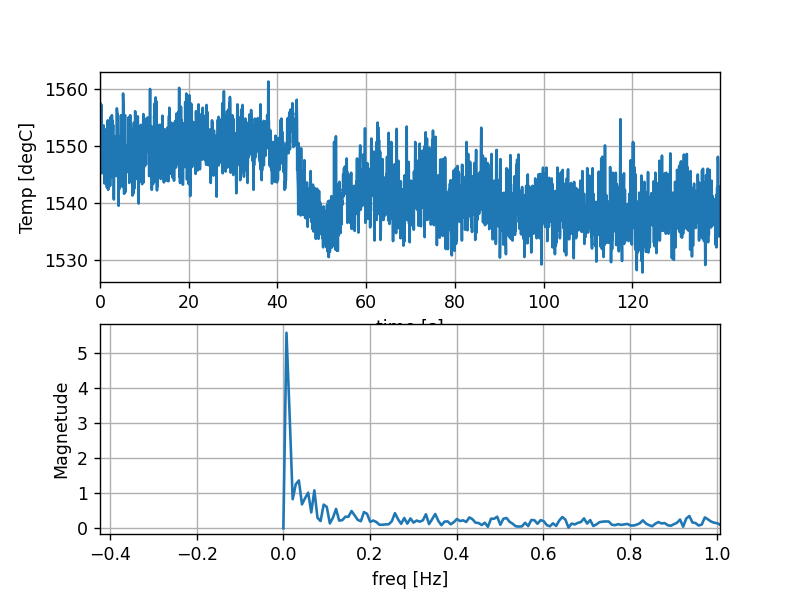

0.0


3494

In [36]:
spitting_freq(tap_str_arr)
len(tap_str_arr)

200


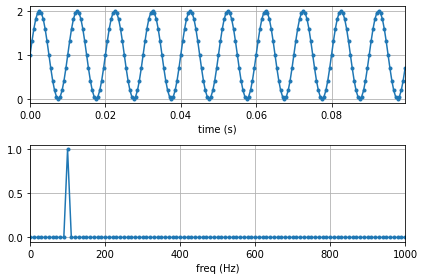

In [47]:
# experiment
# 1st step construct a time signal
Fs = 2000 # sampling freq
tstep = 1 / Fs # sampling time interval
f0 = 100 # signal freq

N = int(10 *Fs/f0) # number of samples 

t = np.linspace(0, (N-1)*tstep, N) # time steps
fstep = Fs / N # freq interval
f = np.linspace(0, (N-1)*fstep, N)

y = 1 * np.sin(2 * np.pi * f0 * t) +1
print(len(y))

# 2nd step perform fft
X = np.fft.fft(y)
X_mag = np.abs(X) / N

f_plot = f[0:int(N/2+1)]
X_mag_plot = 2 * X_mag[0:int(N/2+1)]
X_mag_plot[0] = 0#X_mag_plot[0] / 2 # note DC component does not need to multiply by 2


# plot the signal and frequency spectrum
fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)
ax1.plot(t, y, '.-')
ax2.plot(f_plot, X_mag_plot, '.-')
ax1.set_xlabel('time (s)')
ax2.set_xlabel('freq (Hz)')
ax1.grid()
ax2.grid()

ax1.set_xlim(0, t[-1])
ax2.set_xlim(0, f_plot[-1])
plt.tight_layout()
plt.show()

<h2> Pre processing images

In [25]:
# class methods


def normalize_frame(raw_arr, min_val = 800, max_val = 1600, remove=True):
    """
    Normalize an array to a value between 0 and 1
    Parameters: 
        raw_arr(2D np.array)      :  A 2D numpy array, containing temperature measurementsr
        min_val(int)              :  minimum value of the array (must be consistent accross frames)
        max_val(int)              :  maximum value of the array (must be consistent accross frames)
        remove(bool)              :  if true, will remove all values below min_val, usefull for removing background data
    Returns:
        raw_arr(2D np.array)      :  Normalized 2D array, containing values between 0 and 1.
    """
    low_val_flags = raw_arr < min_val
    raw_arr = (raw_arr - min_val)/(max_val - min_val)
    if(remove):
        raw_arr[low_val_flags] = 0
    return raw_arr
    
def denormalize_arr(processed_arr, min_val=800, max_val=1600):
    """
    Used for getting temperature values from pixel values, by normalizing for 0 to 255 and returning temperature from
    800 to 1600, has an accuracy of +- 5degC
    Parameters:
        processed_arr(2D np.array)    :  image matrix to turn into temperature measurements
        min_val(int)                  :  minimum value of the temperature measurements (must be consistent accross frames)
        max_val(int)                  :  maximum value of the temperature measurements (must be consistent accross frames)
    Returns:
        temperature_arr(2D np.array)  :  2D numpy array containing temperature measurement with lower resolution than
                                         original
    """
    processed_arr = normalize_frame(processed_arr,
                                    min_val=0,max_val=255, remove=False)
    
    temperature_arr = (max_val-min_val)*processed_arr + min_val
    return temperature_arr

def array_to_img(img_mat, show_img=True, save_img=True):
    """
    Converts a 2D numpy array to an image array, can print image.
    Parameters:
        img_mat(2D np.array)          :  Array to be converted to image ready format
        show_img(bool)                :  Print image to screen.
    Returns:
        img_mat(2D np.array)          :  Returns an image ready array.
    """
    #img_mat = np.delete(img_mat,-1,1)
    #img_mat[0][0] = 223.3
    
    # Normalize the array
    img_mat = normalize_frame(img_mat,800,1600)
    
    # Multiply with 255 and convert to Int
    img_mat = img_mat * 255
    img_mat = img_mat.astype(np.uint8)
    
    if(show_img):
        cv.imshow('image', img_mat)
        cv.waitKey()
        cv.destroyAllWindows()
    if(save_img):
        cv.imwrite('test.png', img_mat)
    return img_mat

def binary_masking(img_mat, slag_val, show_img = False):
    """
    Applies binary masking to the image based on slag temperature, this will remove all non slag elements from the image.
    by filtering out all pixels below a specified intensity. will paint slag white and non slag black.
    Parameters:
        img_mat(2D np.array)        :   array to apply binary mask to, must be image ready.
        slag_val(int)               :   Pixel value for the slag to be filtered out
    Returns: 
        binary_mask(2D np.array)    :   Returns image ready 0 and 255 array
    """
    binary_mask = img_mat.copy()
    
    black_flg = binary_mask < slag_val
    white_flg = binary_mask >= slag_val
    binary_mask[black_flg] = 0
    binary_mask[white_flg] = 255
    if(show_img):
        cv.imshow('image', binary_mask)
        cv.waitKey()
        cv.destroyAllWindows()
    return binary_mask

def find2d_index(data2d_arr, value=255):
    """
    Find the index for every white pixel from masking, can be compared with original matrix to
    fetch only slag temperature. Will return coordinates of specified values
    Parameters:
        data2d_arr(2D np.array)        :  array to search for specified value
        value(int)                     :  Specific pixel value to search for.
    Returns:
        index_lst(list)                :  List of tupples containing array index for search values.
    """
    temp_lst = data2d_arr.tolist()
    index_lst = list()
    
    for i, x in enumerate(temp_lst):
        if value in x:
            index_lst.append((i, x.index(value)))
    return index_lst

def find_slag(index_lst, img_mat):
    """
    Will fetch only the slag temperature from given frame.
    Parameters:
        index_lst(list)       :  List of tupples containing location of slag temperature measurements from masking.
        img_mat(2D np.array)  :  Image data 
    Returns:
        slag_lst(list)        :  List of all slag temperature measurements
    """
    slag_lst = list()
    for i in range(0, len(index_lst), 1):
        slag_lst.append(img_mat[index_lst[i]])
    return slag_lst

def find_slag_statistics(img_mat, min_cutoff=220):
    """
    Will filter out all values that does not correspond to slag, will reduce the precision of temperature measurements
    Parameters:
        img_mat(2D np.array)       :  contains the raw data for one frame.
    Returns:
        slag_temp_arr(np.array)    :  contains all the slag temperature measurements from one frame, to further analyse.
    """
    org_mat = img_mat.copy()
    img_mat = array_to_img(img_mat, show_img=False, save_img=True)
    binary_mask_arr = binary_masking(img_mat, min_cutoff, True)

    index_lst = find2d_index(binary_mask_arr)
    slag_lst = find_slag(index_lst, org_mat)
    #print(np.min(slag_lst))
    slag_temp_arr = denormalize_arr(np.array(slag_lst))
    return slag_lst

In [21]:
class Frame:
    
    def __init__(self, img_mat):
        self.raw_mat = img_mat
        self.img_mat = img_mat
        self.conv_to_img = False
        self.conv_binary_mask = False
        
    def normalize_frame(self, min_val = 800, max_val = 1600, remove=True):
        """
        Normalize an array to a value between 0 and 1
        Parameters: 
            raw_arr(2D np.array)      :  A 2D numpy array, containing temperature measurementsr
            min_val(int)              :  minimum value of the array (must be consistent accross frames)
            max_val(int)              :  maximum value of the array (must be consistent accross frames)
            remove(bool)              :  if true, will remove all values below min_val, usefull for removing background data
        Returns:
            raw_arr(2D np.array)      :  Normalized 2D array, containing values between 0 and 1.
        """
        raw_arr = self.raw_mat
        low_val_flags = raw_arr < min_val
        raw_arr = (raw_arr - min_val)/(max_val - min_val)
        if(remove):
            raw_arr[low_val_flags] = 0
        self.img_mat = raw_arr

    def array_to_img(self, show_img=False):
        """
        Converts a 2D numpy array to an image array, can print image.
        Parameters:
            img_mat(2D np.array)          :  Array to be converted to image ready format
            show_img(bool)                :  Print image to screen.
        Returns:
            img_mat(2D np.array)          :  Returns an image ready array.
        """
        #img_mat = np.delete(img_mat,-1,1)
        #img_mat[0][0] = 223.3
        # Multiply with 255 and convert to Int
        
        self.conv_to_img = True
        
        img_mat = self.img_mat
        img_mat = img_mat * 255
        img_mat = img_mat.astype(np.uint8)

        if(show_img):
            cv.imshow('image', img_mat)
            cv.waitKey()
            cv.destroyAllWindows()
        self.img_mat = img_mat

    def binary_masking(self, slag_val, show_img = False):
        """
        Applies binary masking to the image based on slag temperature, this will remove all non slag elements from the image.
        by filtering out all pixels below a specified intensity. will paint slag white and non slag black.
        Parameters:
            img_mat(2D np.array)        :   array to apply binary mask to, must be image ready.
            slag_val(int)               :   Pixel value for the slag to be filtered out
        Returns: 
            binary_mask(2D np.array)    :   Returns image ready 0 and 255 array
        """
        self.conv_binary_mask = True
        img_mat = self.img_mat
        binary_mask = img_mat.copy()

        black_flg = binary_mask < slag_val
        white_flg = binary_mask >= slag_val
        binary_mask[black_flg] = 0
        binary_mask[white_flg] = 255
        if(show_img):
            cv.imshow('image', binary_mask)
            cv.waitKey()
            cv.destroyAllWindows()
        self.binary_mask = binary_mask

    def find2d_index(self, value=255):
        """
        Find the index for every white pixel from masking, can be compared with original matrix to
        fetch only slag temperature. Will return coordinates of specified values
        Parameters:
            data2d_arr(2D np.array)        :  array to search for specified value
            value(int)                     :  Specific pixel value to search for.
        Returns:
            index_lst(list)                :  List of tupples containing array index for search values.
        """
        data2d_arr = self.binary_mask
        temp_lst = data2d_arr.tolist()
        index_lst = list()

        for i, x in enumerate(temp_lst):
            if value in x:
                index_lst.append((i, x.index(value)))
        self.index_lst = index_lst

    def find_slag(self):
        """
        Will fetch only the slag temperature from given frame.
        Parameters:
            index_lst(list)       :  List of tupples containing location of slag temperature measurements from masking.
            img_mat(2D np.array)  :  Image data 
        Returns:
            slag_lst(list)        :  List of all slag temperature measurements
        """
        slag_lst = list()
        for i in range(0, len(self.index_lst), 1):
            slag_lst.append(self.raw_mat[self.index_lst[i]])
        self.slag_lst = slag_lst

    def find_slag_statistics(self, min_cutoff=220):
        """
        Will filter out all values that does not correspond to slag, will reduce the precision of temperature measurements
        Parameters:
            img_mat(2D np.array)       :  contains the raw data for one frame.
        Returns:
            slag_temp_arr(np.array)    :  contains all the slag temperature measurements from one frame, to further analyse.
        """
        self.normalize_frame()
        self.array_to_img(show_img=False)
        self.binary_masking(min_cutoff, False)

        self.find2d_index()
        self.find_slag()
        return self.slag_lst
    
    def save_image(self, path_loc, name, bin_mask = False, crop = (-1,-1)):
        # check if converted to image, if not then convert to image
        if (self.conv_to_img == False):
            self.normalize_frame()
            self.array_to_img()
            
        file = f"{path_loc}/{name}.png"
        
        if (crop[0] != -1):
            self.img_mat = self.img_mat[crop[0]:crop[1], crop[2]:crop[3]]
        img = cv.convertScaleAbs(self.img_mat, alpha=(255.0))
        cv.imwrite(file, self.img_mat)
        if (self.conv_binary_mask and bin_mask):
            file = f"{path_loc}/{name}mask.png"
            img2 = cv.convertScaleAbs(self.binary_mask, alpha=(255.0))
            cv.imwrite(file, img2)

In [22]:
class Album:
    def __init__(self, path):
        """
        Will create an album object with a path, will calculate the number of frames
        in the album
        Parameters:
            path(string)      :   Path to .txt file containing image data
        """
        self.path = path
        self.frames = self.get_nframes()
        
    def get_nframes(self):
        """
        Calculates the number of frames in .txt file
        """
        row_count = sum(1 for row in open(self.path, 'r'))
        return int(row_count/(480+1))
        

    def load_album(self, frames =-1, x=(0,480),y=(0,639)):
        """
        Will load the image data into memory, to a dataframe object.
        Parameters:
            frames(int)         :  Number of frames to load, -1 for all the frames
            x(tupple(int))      :  Image coordinates along x-axis
            y(tupple(int))      :  Image coordinates along y-axis
        """
        self.album = list()
        if (frames == -1):
            frames = self.frames
        print(f'[INFO] Album created {datetime.datetime.now()}')
        f = open(path, 'r')
        #contain timestamp
        for k in range(0,frames,1):
            f.readline()

            #Initialise array of size 480 yo 639 
            temp_arr = np.zeros((480, 639))

            #Seperate values and stores in a dictionary
            for j in range(x[0],x[1],1):
                if(x[0] < j and x[1]-1 > j):
                    string = f.readline()
                    str_list = string.split('\t')
                    str_list=str_list[y[0]:y[1]]
                    #print(str_list[-1])

                    #if not len(str_list)==0:
                    temp_arr[j] = [float(num) for num in str_list]
                    #{temp_dct[str(i)].append(float(str_list[i])) for i in range(0,len(str_list), 1)}

                else:
                    f.readline()

            self.album.append(temp_arr)
            print(f'[INFO] Frame: {k+1}/{frames} is loaded into Album')
        print(f'[INFO] Done {datetime.datetime.now()}')
    
    def find_slag_temp(self, path, save_img = False, crop = (-1, -1)):
        i = 0
        for frame in self.album:
            f = Frame(frame)
            slag_lst = f.find_slag_statistics(220)
            if (save_img):
                f.save_image(path_loc=path, name=str(i), crop=crop)
                i+=1
                
            

In [19]:
#Select the path
#path = 'data/2021_09_12_34.txt'
path = '2_frames.txt'

# create statistics lists for mean, standard deviation, median and max
maxtemp_lst = []
std_lst = []
median_lst = []
mean_lst = []

#create an album object
a = Album(path)

a.load_album()

#array_to_img(temp_arr)


[INFO] Album created 2022-04-26 15:01:14.277086
[INFO] Frame: 1/2 is loaded into Album
[INFO] Frame: 2/2 is loaded into Album
[INFO] Done 2022-04-26 15:01:14.515422


In [18]:
tap_hole = (13, 193, 238, 388)
tap_stream = (170, 400, 238, 388)

a.find_slag_temp('test', True, tap_stream)

In [170]:
#crop = (13, 467, 238, 396)
tap_hole = (13, 193, 238, 388)
tap_stream = (13, 193, 238, 388)


fr = Frame(b.album[0])
fr.normalize_frame()
img = fr.img_mat
img = img[crop[0]:crop[1], crop[2]:crop[3]]
cv.imshow('test', img)
cv.waitKey(0)
cv.destroyAllWindows()

<h2> Staking detection

In [27]:
path = 'staking_test.txt'
b = Album(path)

templist = []

b.load_album()
"""for frame in b.album:
    slagtemp_lst = find_slag_statistics(frame, 0)
    templist.append(slagtemp_lst)
"""

b.find_slag_temp('staking', True)

[INFO] Album created 2022-05-17 22:43:29.479171
[INFO] Frame: 1/27 is loaded into Album
[INFO] Frame: 2/27 is loaded into Album
[INFO] Frame: 3/27 is loaded into Album
[INFO] Frame: 4/27 is loaded into Album
[INFO] Frame: 5/27 is loaded into Album
[INFO] Frame: 6/27 is loaded into Album
[INFO] Frame: 7/27 is loaded into Album
[INFO] Frame: 8/27 is loaded into Album
[INFO] Frame: 9/27 is loaded into Album
[INFO] Frame: 10/27 is loaded into Album
[INFO] Frame: 11/27 is loaded into Album
[INFO] Frame: 12/27 is loaded into Album
[INFO] Frame: 13/27 is loaded into Album
[INFO] Frame: 14/27 is loaded into Album
[INFO] Frame: 15/27 is loaded into Album
[INFO] Frame: 16/27 is loaded into Album
[INFO] Frame: 17/27 is loaded into Album
[INFO] Frame: 18/27 is loaded into Album
[INFO] Frame: 19/27 is loaded into Album
[INFO] Frame: 20/27 is loaded into Album
[INFO] Frame: 21/27 is loaded into Album
[INFO] Frame: 22/27 is loaded into Album
[INFO] Frame: 23/27 is loaded into Album
[INFO] Frame: 24/2

In [26]:
# Staking detection
staking = False
staking_num = 0
for frame in b.album:
    
    mean = np.mean(array_to_img(frame, show_img=False))
    if mean < 2 and staking == False:
        staking_num += 1
        staking = True
    elif mean >= 2 and staking == True:
        staking = False
np.mean(array_to_img(b.album[-1], show_img=False))
print(staking_num)
# 14-20

1


In [14]:
# save test data
img = cv.imread(a.album[0])
cv.imwrite('test', img)

TypeError: Can't convert object to 'str' for 'filename'

In [89]:
# create statistics lists for mean, standard deviation, median and max
maxtemp_lst = []
std_lst = []
median_lst = []
mean_lst = []

for frame in a.album:
    slagtemp_lst = find_slag_statistics(frame)
    maxtemp_lst.append(max(slagtemp_lst))
    std_lst.append(np.std(slagtemp_lst))
    median_lst.append(np.median(slagtemp_lst))
    mean_lst.append(np.mean(slagtemp_lst))
    

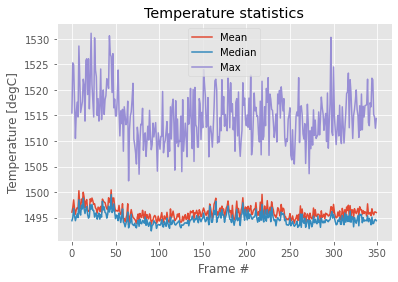

In [114]:
plt.figure()
plt.plot(mean_lst, label='Mean')
plt.plot(median_lst, label='Median')
plt.plot(maxtemp_lst, label='Max')
plt.legend()
plt.ylabel('Temperature [degC]')
plt.xlabel('Frame #')
plt.title('Temperature statistics')
plt.savefig('temperature_statistics.png')
plt.show()
